# Notebook Setup

In [79]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
%matplotlib inline

In [80]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# DiSH-trend

## Simulate

In [81]:
from Simulation.Simulator_Python import simulator_interface as sim
from traces import get_traces

In [82]:
# simulation parameters
model_file = 'example_models/example_model.xlsx'
output_path = 'example_traces'
steps = 30
runs = 200
scenarios = [0]
output_format = 3 # just frequency summaries, not singular runs
scheme = 'ra'

In [95]:
df_model = pd.read_excel(model_file).fillna('')
df_model

Element Name   Element IDs Element Type Notes      Variable  \
0  INTERVENTION  INTERVENTION        other        INTERVENTION   
1         CAUSE         CAUSE        other               CAUSE   
2       PROBLEM       PROBLEM        other             PROBLEM   
3       OUTCOME       OUTCOME        other             OUTCOME   

         Positive                   Negative  Levels Delay Update rate  \
0                                                 11                     
1                                                 11                     
2           CAUSE               INTERVENTION      11                     
3  -0.5&0*PROBLEM  0.5&0.5*PROBLEM+0.5*CAUSE      11                     

  Spontaneous behavior Balancing behavior         Scenario 0  
0                 None               None      0,8[10],6[15]  
1                 None               None  0,6[5],7[9],0[20]  
2                 None               None                  0  
3                 None               None                 10

### Model spreadsheet explained

There are 6 **mandatory** columns:

1) **Element Name** (holds the name for displaying the simulation results)

2) **Variable** (holds the name by which this variable will be referred to in the simulator)

3) **Positive** (holds the string that encodes all POSITIVE regulation of the element)

4) **Negative** (holds the string that encodes all NEGATIVE regulation of the element)

5) **Levels** (the number of the element's discrete levels)

6) **Scenario 0** (contains the initial values for the simulation, and the enforced values at given timesteps)

Note: there can be multiple scenarios in the spreadsheet, each identified by its own initialization (Scenario 0, Scenario 1, Scenario 2, ...)

**Positive** and **Negative** columns are filled the same way. They encode the update functions, where the sources of influence are joined by addition when independently affecting the element (*A*+*B*), or multiplication when jointly affecting the element (*A*\**B*). Each interaction (influence) consists of level-based and/or trend-based component. These are discerned by the level weights and trend weights. *A* singular influence *A*->*C* is encoded as w<sub>t</sub>&w<sub>l</sub>\*A, where w<sub>t</sub> is trend weight, w<sub>l</sub> is level weight, and A is the regulator name. This is decoded by the simulator into an expression:

$w_{t}*dA+w_{l}*A$

where *dA* is the trend of the element **A** (the difference between current value of **A** and its last updated value), and *A* is the level of the element **A**. The weights *w<sub>t</sub>* and *w<sub>l</sub>* should belong to intervals \[-1,1\] and \[0,1\], respectively.

**Note:** the absence of trend-based regulation can be encoded in two ways:

1) by setting $w_{t}=0$

2) by setting only level-based regulation weight (e.g. writing w<sub>l</sub>\*A)

The absence of the level-based regulation can only be encoded by setting $w_{l}=0$ (e.g. writing w<sub>l</sub>&0\*A).

If an element's name is written without weights, it assumes default values of $w_{t}=0$ and $w_{l}=1$.

Due to limitations in classifying regulations as positive or negative, in the current version of the simulator the model spreadsheet requires virtual counterterms on the opposite side of the regulation. The original terms have non-negative weights only, while the counterterms have $w_{t}\le 0$, and $w_{l}=0$

Example \#1: *A **positively** regulates B, with trend weight 0.8, and level weight 0.4*.

In **Positive** column of B: 0.8&0.4\*A

In **Negative** column of B: -0.8&0\*A

Example \#2: *A **negatively** regulates B, with trend weight 0.3, and level weight 0.5*.

In **Positive** column of B: -0.3&0\*A

In **Negative** column of B: 0.3&0.5\*A

Example \#3: *A **positively** regulates C with trend weight 0.8, and level weight 0.4, while B independently of A **negatively** regulates C with trend weight 0.3, and level weight 0.5*.

In **Positive** column of C: 0.8&0.4\*A+-0.3&0\*B

In **Negative** column of C: 0.3&0.5\*B+-0.8&0\*A

Note: the weights don't necessarily add up to 1. They are dynamic parameters that are describing individual interactions.

In [97]:
scenarios_sorted = [str(x) for x in sorted(scenarios)]

# set up output paths
if not os.path.exists(output_path):
    os.mkdir(output_path)
output_basename = os.path.join(output_path,'example_traces')

In [84]:
# simulate 
sim.setup_and_run_simulation(
         model_file, 
         output_basename + '.txt', 
         steps, 
         runs, 
         scheme, 
         output_format,
         ','.join(scenarios_sorted)
         )

INFO:root:Simulation scenario 0 complete


## Visualize simulation results

### Define parameters and load from files

In [85]:
# model and output file locations (same as simulation example above)
model_file = 'example_models/example_model.xlsx'
output_path = 'example_traces'
output_basename = os.path.join(output_path,'example_traces')

In [96]:
df_model = pd.read_excel(model_file).fillna('')

In [87]:
# visualization parameters
scenarios = [0]
colors = None # can be a list of colors, length matching the number of scenarios
linestyles = None # can be a list, length matching the number of scenarios
linewidth = 2
normalize_levels = True # whether to plot y axis as a percentage

In [88]:
# get scenario labels from model
input_col_initial = [x.strip() for x in df_model.columns if ('scenario' in x.lower())]
scenario_labels = [input_col_initial[x] for x in scenarios]

# construct list of trace files automatically generated by the simulator
scenarios_sorted = [str(x) for x in sorted(scenarios)]
if len(scenarios_sorted) > 1:
    trace_files = [
                output_basename + '_' + str(this_scenario) + '.txt'
                for this_scenario in scenarios_sorted
                ]
else:
    trace_files = [output_basename + '.txt']

In [89]:
# get trace data
traces_list = [get_traces(trace_file) for trace_file in trace_files]

In [90]:
traces_list[0].keys()

dict_keys(['CAUSE', 'INTERVENTION', 'OUTCOME', 'PROBLEM'])

In [91]:
traces_list[0]['CAUSE'].keys()

dict_keys(['levels', 'runs', 'frequency', 'squares', 'avg', 'stdev', 'avg_percent', 'stdev_percent'])

### Average plot

Text(0.5, 1.0, 'CAUSE')

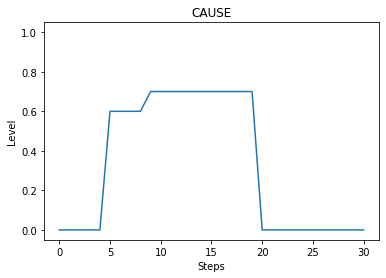

In [92]:
element_name = 'CAUSE'
plt.plot(np.array(traces_list[0][element_name]['avg_percent'])/100.)
plt.xlabel('Steps')
plt.ylabel('Level')
plt.ylim(-0.05,1.05)
plt.title(element_name)

### Average plot with uncertainty

Text(0.5, 1.0, 'OUTCOME')

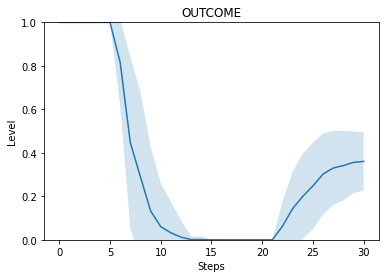

In [93]:
element_name = 'OUTCOME'
avg_perc = np.array(traces_list[0][element_name]['avg_percent'])/100.
stdev_perc = np.array(traces_list[0][element_name]['stdev_percent'])/100.
plt.plot(avg_perc)
plt.fill_between(range(len(avg_perc)), avg_perc-stdev_perc, avg_perc+stdev_perc, alpha=0.2)
plt.xlabel('Steps')
plt.ylabel('Level')
plt.ylim(-0.0001,1.0001)
plt.title(element_name)

### Calibrated plots

Text(0.5, 1.0, 'OUTCOME')

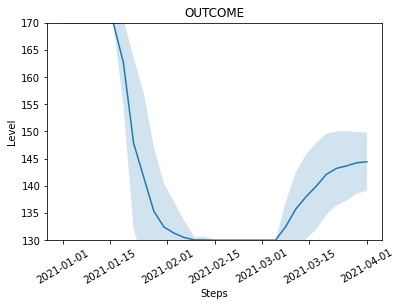

In [94]:
element_name = 'OUTCOME'
avg_perc = np.array(traces_list[0][element_name]['avg_percent'])/100.
stdev_perc = np.array(traces_list[0][element_name]['stdev_percent'])/100.

# Calibrate x-axis
x = pd.date_range('2021-01-01','2021-04-01', periods=len(avg_perc))

# Calibrate y-axis
min_value = 130
max_value = 170
#levels = traces_list[0][element_name]['levels']
y = avg_perc * (max_value - min_value) + min_value
y_stdev = stdev_perc * (max_value - min_value)

plt.plot(x, y)
plt.fill_between(x, y-y_stdev, y+y_stdev, alpha=0.2)
plt.xlabel('Steps')
plt.ylabel('Level')
plt.xticks(rotation=30)
plt.ylim(min_value, max_value)
plt.title(element_name)